In [2]:
from google.colab import drive
import os

# Check if the mount point exists and is not empty, then remove its contents
mountpoint = '/content/drive'

drive.mount(mountpoint)

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, MobileNetV2, EfficientNetB0
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced"
save_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
os.makedirs(save_dir, exist_ok=True)
img_size = (224, 224)
batch_size = 32
num_classes = 2  # Electrical-damage vs Physical-Damage

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
val_gen = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)
test_gen = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 142 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 34 images belonging to 2 classes.


In [ ]:
def build_model(base_model_class, name):
    base_model = base_model_class(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3)
    )
    for layer in base_model.layers:
        layer.trainable = False  # freeze pretrained layers

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
models_to_train = {
    "VGG16": VGG16,
    "ResNet50": ResNet50,
    "InceptionV3": InceptionV3,
    "MobileNetV2": MobileNetV2,
    "EfficientNetB0": EfficientNetB0
}

for name, model_class in models_to_train.items():
    print(f"\nTraining {name}...")
    model = build_model(model_class, name)

    ckpt_path = os.path.join(save_dir, f"Defective_{name}.keras")
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True)
    ]

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=25,
        callbacks=callbacks,
        verbose=1
    )

    # Save the model and history
    model.save(ckpt_path)
    import pickle
    history_path = os.path.join(save_dir, f"Defective_{name}_history.pkl")
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    print(f"{name} training complete! Saved to:", ckpt_path)


Training VGG16...
Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.4917 - loss: 0.7380 - val_accuracy: 0.8000 - val_loss: 0.6457
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 530ms/step - accuracy: 0.5400 - loss: 0.7429 - val_accuracy: 0.8000 - val_loss: 0.6432
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 644ms/step - accuracy: 0.5587 - loss: 0.6690 - val_accuracy: 0.8333 - val_loss: 0.6408
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 596ms/step - accuracy: 0.5446 - loss: 0.7166 - val_accuracy: 0.8333 - val_loss: 0.6385
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 601ms/step - accuracy: 0.5486 - loss: 0.7227 - val_accuracy: 0.8333 - val_loss: 0.6364
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 650ms/step - accuracy: 0.5539 - loss: 0.7368 - val_accuracy: 0.8000 - val_loss: 0.6342
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - accuracy: 0.5559 - loss: 0.6854 - val_accuracy: 0.8000 - val_loss: 0.6320
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - accuracy: 0.5097 - loss: 0.7402 - val_accuracy: 0.

In [ ]:
import os
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Your save directory (update this path)
save_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced"
img_size = (224, 224)
batch_size = 32


# Assuming you already have a test generator defined:
# test_gen = test_datagen.flow_from_directory(...)
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

models = ["VGG16", "ResNet50", "InceptionV3", "MobileNetV2", "EfficientNetB0"]

for name in models:
    print(f"\nEvaluating {name}...")

    # Load model
    ckpt_path = os.path.join(save_dir, f"Defective_{name}.keras")
    model = tf.keras.models.load_model(ckpt_path)

    # Load training history
    history_path = os.path.join(save_dir, f"Defective_{name}_history.pkl")
    with open(history_path, 'rb') as f:
        history = pickle.load(f)

    # Get final (or best) training/validation accuracy
    train_acc = history['accuracy'][-1]
    val_acc = max(history['val_accuracy'])

    # Evaluate on test data
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)

    print(f"Results for {name}:")
    print(f"Training Accuracy:   {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy:       {test_acc:.4f}")

Found 34 images belonging to 2 classes.

Evaluating VGG16...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5496 - loss: 0.6576
Results for VGG16:
Training Accuracy:   0.6901
Validation Accuracy: 0.8333
Test Accuracy:       0.5588

Evaluating ResNet50...
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.7402 - loss: 0.6421
Results for ResNet50:
Training Accuracy:   0.5352
Validation Accuracy: 0.7000
Test Accuracy:       0.7353

Evaluating InceptionV3...
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.8499 - loss: 0.3907
Results for InceptionV3:
Training Accuracy:   0.8310
Validation Accuracy: 0.9333
Test Accuracy:       0.8529

Evaluating MobileNetV2...
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 10s/step - accuracy: 0.7598 - loss: 0.5830
Results for MobileNetV2:
Training Accuracy:   0.7394
Validation Accuracy: 0.9000
Test Accuracy:       0.7647

Evaluating EfficientNetB0...


2/2 ━━━━━━━━━━━━━━━━━━━━ 27s 10s/step - accuracy: 0.4896 - loss: 0.6934
Results for EfficientNetB0:
Training Accuracy:   0.5000
Validation Accuracy: 0.5000
Test Accuracy:       0.5000


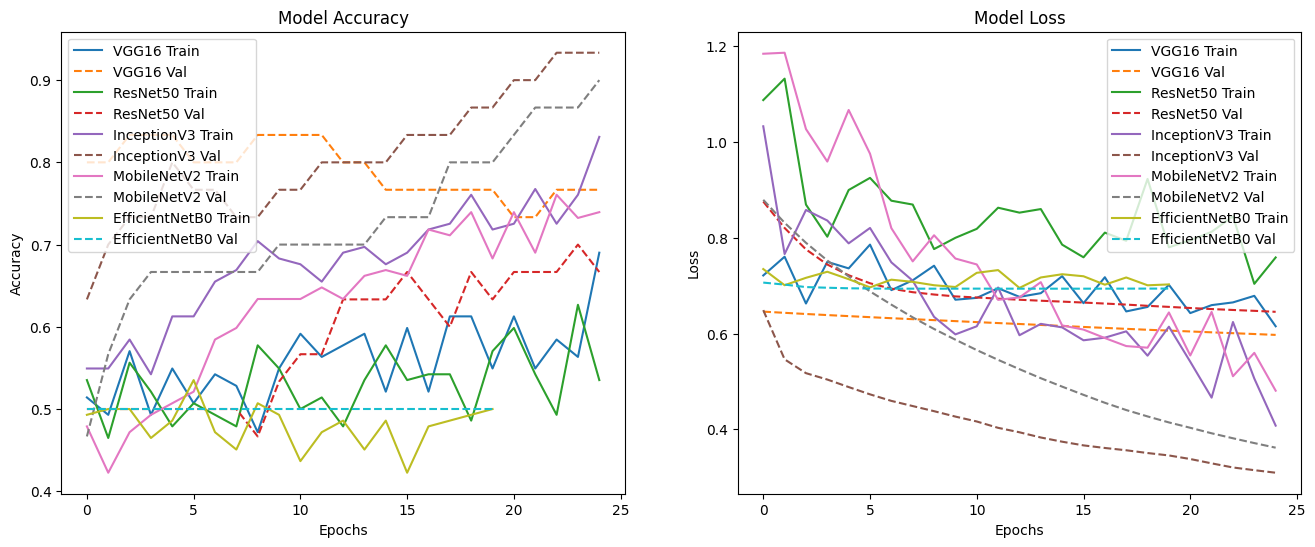

In [ ]:
import matplotlib.pyplot as plt
import pickle
import os

histories = {}
for name in models_to_train.keys():
    history_path = os.path.join(save_dir, f"Defective_{name}_history.pkl")
    if os.path.exists(history_path):
        with open(history_path, 'rb') as f:
            histories[name] = pickle.load(f)
    else:
        print(f"History not found for {name} at {history_path}")


plt.figure(figsize=(16,6))
# Accuracy
plt.subplot(1,2,1)
for name, hist in histories.items():
    plt.plot(hist['accuracy'], label=f'{name} Train')
    plt.plot(hist['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
for name, hist in histories.items():
    plt.plot(hist['loss'], label=f'{name} Train')
    plt.plot(hist['val_loss'], linestyle='--', label=f'{name} Val')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from tensorflow.keras.models import load_model
ensemble_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
ensemble_models = []
for f in os.listdir(ensemble_dir):
    if f.startswith("Defective_") and f.endswith(".keras"):
        path = os.path.join(ensemble_dir, f)
        print("Loading:", path)
        model = load_model(path)
        ensemble_models.append(model)
print(f"Loaded {len(ensemble_models)} models into the ensemble.")


Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_VGG16.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_InceptionV3.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_MobileNetV2.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_EfficientNetB0.keras
Loaded 5 models into the ensemble.


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_defect_type(img_path, ensemble_models):
    """
    Predict defect type (Electrical or Physical damage)
    using ensemble of multi-class models.
    """
    # Load & preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Collect predictions from all models (each outputs [p_electrical, p_physical])
    preds = [model.predict(img_array, verbose=0)[0] for model in ensemble_models]
    avg_pred = np.mean(preds, axis=0)  # average across ensemble

    # Get class with max probability
    class_idx = np.argmax(avg_pred)
    defect_classes = ["Electrical-damage", "Physical-damage"]
    final_label = defect_classes[class_idx]

    print(f"Raw average probabilities: Electrical={avg_pred[0]:.4f}, Physical={avg_pred[1]:.4f}")
    print(f"🧩 Ensemble Prediction: {final_label}")

    return final_label


In [ ]:
img_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Electrical-damage/Electrical (30).jpg"
result = predict_defect_type(img_path, defect_models)

Raw average probabilities: Electrical=0.6943, Physical=0.3057
🧩 Ensemble Prediction: Electrical-damage


In [ ]:
img_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Electrical-damage/Electrical (50).jpg"
result = predict_defect_type(img_path, defect_models)

Raw average probabilities: Electrical=0.6751, Physical=0.3249
🧩 Ensemble Prediction: Electrical-damage


In [ ]:
img_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Physical-Damage/aug_14_Physical (36).jpg"
result = predict_defect_type(img_path, defect_models)

Raw average probabilities: Electrical=0.3063, Physical=0.6937
🧩 Ensemble Prediction: Physical-damage


In [ ]:
img_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Physical-Damage/Physical (51).jpg"
result = predict_defect_type(img_path, defect_models)

Raw average probabilities: Electrical=0.3735, Physical=0.6265
🧩 Ensemble Prediction: Physical-damage


In [ ]:
import numpy as np

def ensemble_predict(models, generator):
    preds = [m.predict(generator, verbose=0) for m in models]
    avg_preds = np.mean(preds, axis=0)
    return avg_preds


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


                   precision    recall  f1-score   support

Electrical-damage       0.80      0.71      0.75        17
  Physical-Damage       0.74      0.82      0.78        17

         accuracy                           0.76        34
        macro avg       0.77      0.76      0.76        34
     weighted avg       0.77      0.76      0.76        34



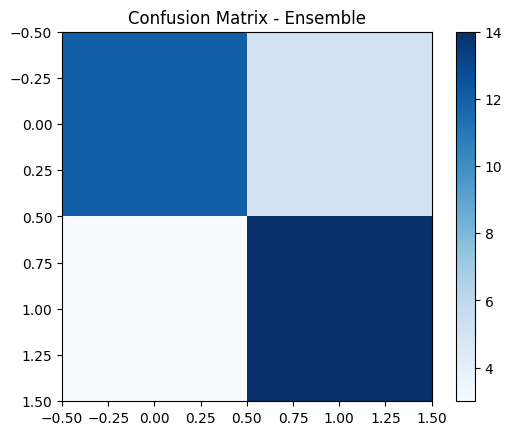

In [ ]:
avg_preds = ensemble_predict(ensemble_models, test_gen)

# Convert probabilities to class labels
y_pred = np.argmax(avg_preds, axis=1)
y_true = test_gen.classes

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix - Ensemble')
plt.colorbar()
plt.show()


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# === CONFIGURATION ===
binary_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results"
defect_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"

IMG_SIZE = (224, 224)
# --- Define focal loss used during training ---
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=1))

# Register custom function
from tensorflow.keras.saving import register_keras_serializable
register_keras_serializable(package="Custom", name="focal_loss_fixed")(focal_loss_fixed)

# === LOAD MODELS ===
def load_ensemble_models(model_dir, prefix_filter=None):
    models = []
    for f in os.listdir(model_dir):
        if f.endswith(".keras") and (prefix_filter is None or prefix_filter in f):
            path = os.path.join(model_dir, f)
            print("Loading:", path)
            models.append(load_model(path, custom_objects={"focal_loss_fixed": focal_loss_fixed}))
    print(f"Loaded {len(models)} models from {model_dir}")
    return models
binary_models = load_ensemble_models(binary_models_dir)
defect_models = load_ensemble_models(defect_models_dir, prefix_filter="Defective_")
# === ENSEMBLE PREDICT ===
def ensemble_predict(models, img_array):
    preds = [m.predict(img_array, verbose=0) for m in models]
    avg_pred = np.mean(preds, axis=0)
    return avg_pred
# === IMAGE PREPROCESS ===
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x
# === FINAL PIPELINE ===
def classify_image(img_path):
    img_array = prepare_image(img_path)
    # Stage 1: Binary classification
    binary_pred = ensemble_predict(binary_models, img_array)
    binary_prob = binary_pred[0][0]  # assuming output shape (1, 1)
    print(f"\nBinary probability (defective): {binary_prob:.3f}")
    if binary_prob < 0.5:
        binary_label = "Defective"
    else:
        binary_label = "Non-Defective"
    # Stage 2: Defect type classification (only if defective)
    if binary_label == "Defective":
        defect_pred = ensemble_predict(defect_models, img_array)
        class_idx = np.argmax(defect_pred)
        defect_classes = ["Electrical-damage", "Physical-damage"]
        defect_label = defect_classes[class_idx]
        final_label = f"Defective – {defect_label}"
        print(f"Defect probabilities: {defect_pred}")
    else:
        final_label = "Non-Defective"
    print(f"\nFinal Prediction: {final_label}")
    return final_label


Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_VGG16.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_InceptionV3.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_EfficientNetB0.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_MobileNetV2.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_VGG16.keras
Loading: /cont

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved op

Loaded 21 models from /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_VGG16.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_InceptionV3.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_MobileNetV2.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results/Defective_EfficientNetB0.keras
Loaded 5 models from /content/drive/MyDrive/Project/solarPanelDef

In [ ]:
!ls /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/

Electrical-damage  Physical-Damage


In [ ]:
# Example test image
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Electrical-damage/Electrical (30).jpg"
label = classify_image(test_image)



Binary probability (defective): 0.339
Defect probabilities: [[0.694318   0.30568197]]

Final Prediction: Defective – Electrical-damage


In [ ]:
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Physical-Damage/aug_31_Physical (57).jpg"
label = classify_image(test_image)


Binary probability (defective): 0.487
Defect probabilities: [[0.37990257 0.62009746]]

Final Prediction: Defective – Physical-damage


In [ ]:
import os

# ✅ Define where to save
save_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/combinedDefScript.py"

# ✅ Make sure the folder exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# ✅ Your full pipeline script as a string
script_content = """
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable

# === CONFIGURATION ===
binary_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results"
defect_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
IMG_SIZE = (224, 224)

# --- Define focal loss used during training ---
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=1))

# Register custom function
register_keras_serializable(package="Custom", name="focal_loss_fixed")(focal_loss_fixed)

# === LOAD MODELS ===
def load_ensemble_models(model_dir, prefix_filter=None):
    models = []
    for f in os.listdir(model_dir):
        if f.endswith(".keras") and (prefix_filter is None or prefix_filter in f):
            path = os.path.join(model_dir, f)
            print("Loading:", path)
            models.append(load_model(path, custom_objects={"focal_loss_fixed": focal_loss_fixed}))
    print(f"Loaded {len(models)} models from {model_dir}")
    return models

binary_models = load_ensemble_models(binary_models_dir)
defect_models = load_ensemble_models(defect_models_dir, prefix_filter="Defective_")

# === ENSEMBLE PREDICT ===
def ensemble_predict(models, img_array):
    preds = [m.predict(img_array, verbose=0) for m in models]
    avg_pred = np.mean(preds, axis=0)
    return avg_pred

# === IMAGE PREPROCESS ===
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x

# === FINAL PIPELINE ===
def classify_image(img_path):
    img_array = prepare_image(img_path)
    # Stage 1: Binary classification
    binary_pred = ensemble_predict(binary_models, img_array)
    binary_prob = binary_pred[0][0]  # assuming output shape (1, 1)
    print(f"\\nBinary probability (defective): {binary_prob:.3f}")
    if binary_prob < 0.5:
        binary_label = "Defective"
    else:
        binary_label = "Non-Defective"

    # Stage 2: Defect type classification (only if defective)
    if binary_label == "Defective":
        defect_pred = ensemble_predict(defect_models, img_array)
        class_idx = np.argmax(defect_pred)
        defect_classes = ["Electrical-damage", "Physical-damage"]
        defect_label = defect_classes[class_idx]
        final_label = f"Defective – {defect_label}"
        print(f"Defect probabilities: {defect_pred}")
    else:
        final_label = "Non-Defective"

    print(f"\\nFinal Prediction: {final_label}")
    return final_label


if __name__ == "__main__":
    test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test/Electrical-damage/Electrical (30).jpg"
    classify_image(test_image)
"""

# Write it to your Drive
with open(save_path, "w") as f:
    f.write(script_content)

print(f"Script saved successfully at: {save_path}")


Script saved successfully at: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/combinedDefScript.py


In [ ]:
test_dir_binary = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/SplitBalanced_batch_1/test"
test_dir_defective = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test"


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

def evaluate_ensemble(models, test_dir, class_labels, img_size=(224,224), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)
    test_gen = datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Get predictions from all models
    all_preds = [m.predict(test_gen, verbose=0) for m in models]
    avg_preds = np.mean(all_preds, axis=0)
    y_pred = np.argmax(avg_preds, axis=1)
    y_true = test_gen.classes

    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Ensemble")
    plt.show()

    # ROC Curve (only for binary)
    if len(class_labels) == 2:
        fpr, tpr, _ = roc_curve(y_true, avg_preds[:,1])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Ensemble')
        plt.legend()
        plt.show()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def evaluate_ensemble_with_model_comparison_and_save(models, model_names, test_dir, class_labels, csv_path, img_size=(224,224), batch_size=32):
    """
    Evaluate ensemble + individual models, visualize performance, and save metrics to CSV.
    """

    # === Step 1: Load Test Data ===
    datagen = ImageDataGenerator(rescale=1./255)
    test_gen = datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    y_true = test_gen.classes
    class_indices = test_gen.class_indices
    print(f"\nClass mapping: {class_indices}")

    metrics_list = []  # store per-model metrics

    # === Step 2: Individual model evaluations ===
    all_preds = []
    for i, m in enumerate(models):
        preds = m.predict(test_gen, verbose=0)
        all_preds.append(preds)

        # Handle different output shapes for binary models
        if preds.shape[-1] == 1:
            y_pred_i = (preds > 0.5).astype(int).flatten() # Convert sigmoid output to binary class
        else:
            y_pred_i = np.argmax(preds, axis=1)

        acc = accuracy_score(y_true, y_pred_i)
        report = classification_report(y_true, y_pred_i, target_names=class_labels, output_dict=True)
        print(f"{model_names[i]} Accuracy: {acc:.3f}")

        metrics_list.append({
            "Model": model_names[i],
            "Accuracy": acc,
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "F1-Score": report["weighted avg"]["f1-score"]
        })

    # === Step 3: Ensemble prediction ===
    avg_preds = np.mean(all_preds, axis=0)

    # Handle different output shapes for ensemble predictions
    if avg_preds.shape[-1] == 1:
        y_pred = (avg_preds > 0.5).astype(int).flatten() # Convert sigmoid output to binary class
    else:
        y_pred = np.argmax(avg_preds, axis=1)

    ensemble_acc = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    print(f"\n✅ Ensemble Accuracy: {ensemble_acc:.3f}")

    # Save ensemble metrics
    metrics_list.append({
        "Model": "Ensemble",
        "Accuracy": ensemble_acc,
        "Precision": report["weighted avg"]["precision"],
        "Recall": report["weighted avg"]["recall"],
        "F1-Score": report["weighted avg"]["f1-score"]
    })

    # === Step 4: Visualizations ===
    print("\n=== Classification Report (Ensemble) ===")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - Ensemble")
    plt.show()

    # ROC Curve (for binary only)
    if len(class_labels) == 2:
        # Determine the probability for the positive class for ROC curve
        if avg_preds.shape[-1] == 1:
            # If output is (n_samples, 1), assume it's the probability of the positive class (index 1)
            y_score = avg_preds.flatten()
        else:
            # If output is (n_samples, 2), take the probability of the positive class (index 1)
            y_score = avg_preds[:, 1]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Ensemble')
        plt.legend()
        plt.show()

    # Bar Chart for Accuracy Comparison
    df_metrics = pd.DataFrame(metrics_list)
    plt.figure(figsize=(8,5))
    plt.bar(df_metrics["Model"], df_metrics["Accuracy"], color=['#66b3ff']*(len(models)) + ['#ffcc00'])
    plt.ylabel("Accuracy")
    plt.title("Per-model vs Ensemble Accuracy Comparison")
    for i, acc in enumerate(df_metrics["Accuracy"]):
        plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=10)
    plt.ylim(0, 1)
    plt.show()

    # === Step 5: Save to CSV ===
    os.makedirs(os.path.dirname(csv_path), exist_ok=True)
    df_metrics.to_csv(csv_path, index=False)
    print(f"\n📁 Metrics saved to: {csv_path}")

    return df_metrics

In [ ]:
import os
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable

# --- Define focal loss used during training ---
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=1))

# Register custom function
register_keras_serializable(package="Custom", name="focal_loss_fixed")(focal_loss_fixed)

# === LOAD MODELS ===
def load_ensemble_models(model_dir, prefix_filter=None):
    models = []
    for f in os.listdir(model_dir):
        if f.endswith(".keras") and (prefix_filter is None or prefix_filter in f):
            path = os.path.join(model_dir, f)
            print("Loading:", path)
            models.append(load_model(path, custom_objects={"focal_loss_fixed": focal_loss_fixed}))
    print(f"Loaded {len(models)} models from {model_dir}")
    return models

# Load binary models
binary_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results"
binary_models = load_ensemble_models(binary_models_dir)

# Define variables for binary evaluation
binary_labels = ["Defective", "Non-Defective"]
binary_model_names = [f"Binary_{i+1}" for i in range(len(binary_models))]
test_dir_binary = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/test"
csv_binary = "/content/drive/MyDrive/Project/metrics/binary_ensemble_metrics.csv"

Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_VGG16.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_InceptionV3.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_EfficientNetB0.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_MobileNetV2.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_VGG16.keras
Loading: /cont

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved op

Loaded 21 models from /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
defect_labels = ["Electrical-damage", "Physical-damage"]
evaluate_ensemble(defect_models, test_dir_defective, defect_labels)

In [ ]:
binary_labels = ["Defective", "Non-Defective"]
binary_model_names = [f"Binary_{i+1}" for i in range(len(binary_models))]
test_dir_binary = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/test"  # adjust if different

csv_binary = "/content/drive/MyDrive/Project/metrics/binary_ensemble_metrics.csv"

evaluate_ensemble_with_model_comparison_and_save(
    binary_models,
    binary_model_names,
    test_dir_binary,
    binary_labels,
    csv_binary
)


In [ ]:
defect_labels = ["Electrical-damage", "Physical-damage"]
defect_model_names = [f"Defective_{i+1}" for i in range(len(defect_models))]
test_dir_defective = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/test"

csv_defective = "/content/drive/MyDrive/Project/metrics/defective_ensemble_metrics.csv"

evaluate_ensemble_with_model_comparison_and_save(
    defect_models,
    defect_model_names,
    test_dir_defective,
    defect_labels,
    csv_defective
)


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, EfficientNetB0, MobileNetV2
)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# === CONFIG ===
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits"
model_save_root = os.path.join(base_dir, "model_results")
os.makedirs(model_save_root, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25  # increase if you want more training

# === Model dictionary ===
base_models = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0,
    "MobileNetV2": MobileNetV2
}

# === Function to build a model ===
def build_model(model_name):
    base_model = base_models[model_name](weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# === Loop through each batch ===
for batch in ["batch_1_split", "batch_2_split", "batch_3_split"]:
    print(f"\nTraining on {batch} ...")
    batch_path = os.path.join(base_dir, batch)

    # Train/Val/Test directories
    train_dir = os.path.join(batch_path, "train")
    val_dir = os.path.join(batch_path, "val")
    test_dir = os.path.join(batch_path, "test")

    # Data generators
    train_gen = ImageDataGenerator(rescale=1./255)
    val_gen = ImageDataGenerator(rescale=1./255)
    test_gen = ImageDataGenerator(rescale=1./255)

    train_data = train_gen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
    val_data = val_gen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
    test_data = test_gen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)

    # Folder to save results for this batch
    batch_model_dir = os.path.join(model_save_root, batch)
    os.makedirs(batch_model_dir, exist_ok=True)

    # === Train each model ===
    for model_name in base_models.keys():
        print(f"\nTraining {model_name} on {batch} ...")
        model = build_model(model_name)

        save_path = os.path.join(batch_model_dir, f"{batch}_{model_name}.keras")

        checkpoint = ModelCheckpoint(save_path, monitor="val_accuracy", save_best_only=True, verbose=1)
        early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=EPOCHS,
            callbacks=[checkpoint, early_stop],
            verbose=1
        )

        # Evaluate on test set
        test_loss, test_acc = model.evaluate(test_data, verbose=0)
        print(f"{model_name} Test Accuracy: {test_acc:.4f}")

print("\nAll batches and models trained successfully!")


Training on batch_1_split ...
Found 270 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 60 images belonging to 2 classes.

Training ResNet50 on batch_1_split ...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5958 - loss: 0.7111
Epoch 1: val_accuracy improved from -inf to 0.48214, saving model to /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split/batch_1_split_ResNet50.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 108s 6s/step - accuracy: 0.6051 - loss: 0.6991 - val_accuracy: 0.4821 - val_loss: 0.7463
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.9710 - loss: 0.1275
Epoch 2: val_accuracy did not improve from 0.48214
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9720 - loss: 0.1246 - val_accuracy: 0.4643 - val_loss: 0.7348
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 1.0000 - loss: 0.0245
Epoch 3: val_accuracy improved from 0.48214 to 0.50000, saving model to /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split/batch_1_split_ResNet50.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 

In [ ]:
import os
import gc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, EfficientNetB0, MobileNetV2
)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# =========================================================
# CONFIG
# =========================================================
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits"
model_save_root = os.path.join(base_dir, "model_results")
os.makedirs(model_save_root, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25  # adjust as needed

# =========================================================
# DEFINE BASE MODELS
# =========================================================
base_models = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0,
    "MobileNetV2": MobileNetV2
}

# =========================================================
# FUNCTION: Build model
# =========================================================
def build_model(model_name):
    base_model = base_models[model_name](weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    output = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# =========================================================
# FUNCTION: Clear GPU Memory
# =========================================================
def clear_memory():
    tf.keras.backend.clear_session()
    gc.collect()
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# =========================================================
# TRAINING LOOP
# =========================================================
for batch in ["batch_1_split", "batch_2_split", "batch_3_split"]:
    print(f"\nTraining on {batch} ...")
    batch_path = os.path.join(base_dir, batch)

    train_dir = os.path.join(batch_path, "train")
    val_dir = os.path.join(batch_path, "val")
    test_dir = os.path.join(batch_path, "test")

    # Data generators
    datagen = ImageDataGenerator(rescale=1./255)
    train_data = datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
    val_data = datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary")
    test_data = datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="binary", shuffle=False)

    # Folder to save models for this batch
    batch_model_dir = os.path.join(model_save_root, batch)
    os.makedirs(batch_model_dir, exist_ok=True)

    # Train each model
    for model_name in base_models.keys():
        save_path = os.path.join(batch_model_dir, f"{batch}_{model_name}.keras")

        # Skip already completed models
        if os.path.exists(save_path):
            print(f"Skipping {model_name} for {batch} (already trained).")
            continue

        print(f"\n🚀 Training {model_name} on {batch} ...")
        model = build_model(model_name)

        checkpoint = ModelCheckpoint(save_path, monitor="val_accuracy", save_best_only=True, verbose=1)
        early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

        # Train model
        history = model.fit(
            train_data,
            validation_data=val_data,
            epochs=EPOCHS,
            callbacks=[checkpoint, early_stop],
            verbose=1
        )

        # Evaluate model
        test_loss, test_acc = model.evaluate(test_data, verbose=0)
        print(f"{model_name} Test Accuracy: {test_acc:.4f}")

        # ✅ Free memory
        clear_memory()

print("\n🎉 All batches and models trained successfully!")


Could not set GPU memory growth: Physical devices cannot be modified after being initialized

Training on batch_1_split ...
Found 270 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Skipping ResNet50 for batch_1_split (already trained).
Skipping VGG16 for batch_1_split (already trained).
Skipping InceptionV3 for batch_1_split (already trained).
Skipping EfficientNetB0 for batch_1_split (already trained).
Skipping MobileNetV2 for batch_1_split (already trained).

Training on batch_2_split ...
Found 270 images belonging to 2 classes.
Found 56 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Skipping ResNet50 for batch_2_split (already trained).
Skipping VGG16 for batch_2_split (already trained).
Skipping InceptionV3 for batch_2_split (already trained).
Skipping EfficientNetB0 for batch_2_split (already trained).
Skipping MobileNetV2 for batch_2_split (already trained).

Training on batch_3_split ...
Foun

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.6420 - loss: 0.6230
Epoch 1: val_accuracy improved from -inf to 0.62222, saving model to /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_3_split/batch_3_split_InceptionV3.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 142s 11s/step - accuracy: 0.6499 - loss: 0.6157 - val_accuracy: 0.6222 - val_loss: 1.2750
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 887ms/step - accuracy: 0.9709 - loss: 0.2506
Epoch 2: val_accuracy did not improve from 0.62222
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9682 - loss: 0.2481 - val_accuracy: 0.6222 - val_loss: 1.5812
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9914 - loss: 0.1050
Epoch 3: val_accuracy did not improve from 0.62222
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9913 - loss: 0.1035 - val_accuracy: 0.6222 - val_loss: 1.7418
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 1.0000 - loss: 0.0566
Epoch

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# === CONFIGURATION ===
model_root = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results"
IMG_SIZE = (224, 224)

# --- Custom loss (if needed, e.g., focal_loss_fixed used in earlier stages) ---
# Assuming focal_loss_fixed is defined and registered if needed for loading
try:
    from tensorflow.keras.saving import register_keras_serializable
    # Define focal loss if it was used during training
    def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.mean(K.sum(loss, axis=1))

    # Register custom function if it hasn't been already
    if "focal_loss_fixed" not in tf.keras.saving.get_custom_objects():
         register_keras_serializable(package="Custom", name="focal_loss_fixed")(focal_loss_fixed)
         print("Registered focal_loss_fixed.")
except ImportError:
    print("TensorFlow version does not support register_keras_serializable or focal_loss_fixed is not needed.")
    focal_loss_fixed = None # Define as None if not available or needed


# === LOAD ALL MODELS (from all batches) ===
def load_all_models(root_dir):
    models = []
    loaded_count = 0
    for batch in os.listdir(root_dir):
        batch_dir = os.path.join(root_dir, batch)
        if not os.path.isdir(batch_dir):
            continue
        for f in os.listdir(batch_dir):
            if f.endswith(".keras"):
                path = os.path.join(batch_dir, f)
                try:
                    print(f"Attempting to load: {path}")
                    # Pass custom_objects only if focal_loss_fixed was defined/registered
                    custom_objects = {"focal_loss_fixed": focal_loss_fixed} if focal_loss_fixed else None
                    model = load_model(path, custom_objects=custom_objects)
                    models.append(model)
                    loaded_count += 1
                    print("Successfully loaded.")
                except Exception as e:
                    print(f"Error loading model {path}: {e}. Skipping this model.")

    print(f"\nSuccessfully loaded {loaded_count} models out of {len(os.listdir(batch_dir) * len(os.listdir(root_dir)) if os.path.exists(batch_dir) else 0)} potential models.") # Adjusted count
    return models

ensemble_models = load_all_models(model_root)

# === IMAGE PREPROCESS ===
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x

# === ENSEMBLE PREDICTION ===
def ensemble_predict(models, img_array):
    # Ensure there are models to predict with
    if not models:
        print("No models available for prediction.")
        return None, []

    preds = []
    for m in models:
        try:
            # Assuming binary output (1, 1)
            pred = m.predict(img_array, verbose=0)[0][0]
            preds.append(pred)
        except Exception as e:
            print(f"Error during prediction for one model: {e}. Skipping this model for this prediction.")
            continue # Skip this model for this prediction

    if not preds:
        print("No successful predictions from any model.")
        return None, []

    avg_pred = np.mean(preds)
    return avg_pred, preds

# === FINAL FUNCTION ===
def classify_clean_vs_nonclean(img_path):
    img_array = prepare_image(img_path)
    avg_pred, preds = ensemble_predict(ensemble_models, img_array)

    if avg_pred is None:
        print("\nCould not make a prediction.")
        return "Prediction Failed"

    print("\nIndividual model predictions:")
    print([round(p, 4) for p in preds])
    print(f"\nAverage ensemble prediction: {avg_pred:.4f}")

    if avg_pred < 0.5:
        print("Ensemble Prediction: Clean")
        return "Clean"
    else:
        print("Ensemble Prediction: Non-Clean")
        return "Non-Clean"

Registered focal_loss_fixed.
Attempting to load: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split/batch_1_split_ResNet50.keras
Successfully loaded.
Attempting to load: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split/batch_1_split_VGG16.keras
Successfully loaded.
Attempting to load: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split/batch_1_split_InceptionV3.keras
Successfully loaded.
Attempting to load: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split/batch_1_split_EfficientNetB0.keras
Successfully loaded.
Attempting to load: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_1_split/batch_1_split_MobileNetV2.keras
Successfully loade

In [ ]:

# === TEST WITH CUSTOM IMAGE ===
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/batch_1_split/test/Clean/Clean (150).jpg"
result = classify_clean_vs_nonclean(test_image)



Individual model predictions:
[np.float32(0.363), np.float32(0.003), np.float32(0.0005), np.float32(0.4837), np.float32(0.0643), np.float32(0.4617), np.float32(0.018), np.float32(0.0004), np.float32(0.5077), np.float32(0.0781), np.float32(0.1266), np.float32(0.0), np.float32(0.3974), np.float32(0.1748)]

Average ensemble prediction: 0.1914
Ensemble Prediction: Clean


In [ ]:

# === TEST WITH CUSTOM IMAGE ===
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/batch_3_split/test/Clean/Clean (28).jpg"
result = classify_clean_vs_nonclean(test_image)



Individual model predictions:
[np.float32(0.2981), np.float32(0.2484), np.float32(0.0017), np.float32(0.4842), np.float32(0.2471), np.float32(0.4626), np.float32(0.0148), np.float32(0.0003), np.float32(0.5081), np.float32(0.0036), np.float32(0.3266), np.float32(0.0), np.float32(0.3964), np.float32(0.1158)]

Average ensemble prediction: 0.2220
Ensemble Prediction: Clean


In [ ]:

# === TEST WITH CUSTOM IMAGE ===
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/batch_3_split/test/NonClean/Bird (74).jpg"
result = classify_clean_vs_nonclean(test_image)



Individual model predictions:
[np.float32(0.3541), np.float32(0.9901), np.float32(0.9999), np.float32(0.4865), np.float32(0.2287), np.float32(0.463), np.float32(0.9893), np.float32(0.9888), np.float32(0.5101), np.float32(0.4138), np.float32(0.9594), np.float32(0.9914), np.float32(0.3978), np.float32(0.1395)]

Average ensemble prediction: 0.6366
Ensemble Prediction: Non-Clean


In [ ]:

# === TEST WITH CUSTOM IMAGE ===
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/batch_3_split/test/NonClean/Dust (97).jpg"
result = classify_clean_vs_nonclean(test_image)



Individual model predictions:
[np.float32(0.3347), np.float32(0.994), np.float32(0.9865), np.float32(0.4839), np.float32(0.1191), np.float32(0.4699), np.float32(0.9501), np.float32(0.9621), np.float32(0.507), np.float32(0.0474), np.float32(0.8875), np.float32(0.6487), np.float32(0.3972), np.float32(0.4036)]

Average ensemble prediction: 0.5851
Ensemble Prediction: Non-Clean


In [ ]:
print(train_data.class_indices)


{'Clean': 0, 'NonClean': 1}


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable

# === CONFIGURATION ===
binary_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results"
defect_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
nondef_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results"
IMG_SIZE = (224, 224)

# --- Define focal loss (if used during training) ---
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=1))

register_keras_serializable(package="Custom", name="focal_loss_fixed")(focal_loss_fixed)

# === LOAD MODELS ===
def load_ensemble_models(model_dir):
    models = []
    keras_files = sorted([f for f in os.listdir(model_dir) if f.endswith(".keras")])
    if not keras_files:
        raise FileNotFoundError(f"No .keras models found in {model_dir}")

    for f in keras_files:
        path = os.path.join(model_dir, f)
        print(f"Loading model: {path}")
        try:
            model = load_model(path, custom_objects={"focal_loss_fixed": focal_loss_fixed})
            models.append(model)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")

    print(f"Loaded {len(models)} models from {model_dir}")
    return models


# Load model ensembles for all 3 stages
print("\n--- Loading Binary Models ---")
binary_models = load_ensemble_models(binary_models_dir)

print("\n--- Loading Defect Type Models ---")
defect_models = load_ensemble_models(defect_models_dir)

print("\n--- Loading Non-Defective Models ---")
nondef_models = load_ensemble_models(nondef_models_dir)

# === UTILITY FUNCTIONS ===
def ensemble_predict(models, img_array):
    preds = [m.predict(img_array, verbose=0) for m in models]
    avg_pred = np.mean(preds, axis=0)
    return avg_pred

def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x

# === FINAL PIPELINE ===
def classify_image(img_path):
    print(f"\nAnalyzing image: {os.path.basename(img_path)}")
    img_array = prepare_image(img_path)

    # === STAGE 1: Binary (Defective / Non-Defective) ===
    binary_pred = ensemble_predict(binary_models, img_array)
    binary_prob = binary_pred[0][0]  # sigmoid output
    print(f"Binary probability (Non-Defective): {binary_prob:.3f}")

    if binary_prob < 0.5:
        binary_label = "Defective"
    else:
        binary_label = "Non-Defective"

    # === STAGE 2A: Defect classification ===
    if binary_label == "Defective":
        defect_pred = ensemble_predict(defect_models, img_array)
        class_idx = np.argmax(defect_pred)
        defect_classes = ["Electrical-damage", "Physical-damage"]
        defect_label = defect_classes[class_idx]
        print(f"Defect probabilities: {defect_pred}")
        final_label = f"Defective → {defect_label}"

    # === STAGE 2B: Non-defective classification ===
    else:
        nondef_pred = ensemble_predict(nondef_models, img_array)
        nondef_prob = nondef_pred[0][0]
        print(f"Non-Defective probability (Non-Clean): {nondef_prob:.3f}")

        if nondef_prob >= 0.5:
            nondef_label = "Non-Clean"
        else:
            nondef_label = "Clean"

        final_label = f"Non-Defective → {nondef_label}"

    print(f"\nFINAL PREDICTION: {final_label}")
    return final_label



--- Loading Binary Models ---
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_EfficientNetB0.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_InceptionV3.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_MobileNetV2.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_ResNet50.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_VGG16.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_EfficientNetB0.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 90 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved op

Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_InceptionV3.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_MobileNetV2.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_ResNet50.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_3_VGG16.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_EfficientNetB0.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_4_InceptionV3.keras
Loading model: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/Spl

In [ ]:
!ls /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results

batch_1_split_EfficientNetB0.keras  batch_2_split_ResNet50.keras
batch_1_split_InceptionV3.keras     batch_2_split_VGG16.keras
batch_1_split_MobileNetV2.keras     batch_3_split_EfficientNetB0.keras
batch_1_split_ResNet50.keras	    batch_3_split_InceptionV3.keras
batch_1_split_VGG16.keras	    batch_3_split_MobileNetV2.keras
batch_2_split_EfficientNetB0.keras  batch_3_split_ResNet50.keras
batch_2_split_InceptionV3.keras     batch_3_split_VGG16.keras
batch_2_split_MobileNetV2.keras


In [ ]:

# === TEST WITH CUSTOM IMAGE ===
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/batch_1_split/test/Clean/Clean (150).jpg"
result = classify_image(test_image)



Analyzing image: Clean (150).jpg


Binary probability (Non-Defective): 0.625
Non-Defective probability (Non-Clean): 0.191

FINAL PREDICTION: Non-Defective → Clean


In [ ]:

# === TEST WITH CUSTOM IMAGE ===
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/batch_3_split/test/NonClean/Bird (74).jpg"
result = classify_image(test_image)



Analyzing image: Bird (74).jpg
Binary probability (Non-Defective): 0.666
Non-Defective probability (Non-Clean): 0.637

FINAL PREDICTION: Non-Defective → Non-Clean


In [ ]:
import os

base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean"

# Valid image extensions
exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

counts = {}
total = 0

for category in sorted(os.listdir(base_dir)):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path):
        num_images = sum(1 for f in os.listdir(category_path) if f.endswith(exts))
        counts[category] = num_images
        total += num_images

print("Image counts per Non-Clean category:")
for k, v in counts.items():
    print(f"  {k}: {v} images")

print(f"\nTotal Non-Clean images: {total}")


📊 Image counts per Non-Clean category:
  Bird-drop: 191 images
  Dusty: 190 images
  Snow-Covered: 123 images

Total Non-Clean images: 504


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
from PIL import Image

# Paths
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean"
augmented_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented"
os.makedirs(augmented_dir, exist_ok=True)

# Image generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)

IMG_SIZE = (224, 224)
target_count = 191
exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

for cls in sorted(os.listdir(base_dir)):
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    files = [f for f in os.listdir(cls_path) if f.endswith(exts)]
    count = len(files)
    save_dir = os.path.join(augmented_dir, cls)
    os.makedirs(save_dir, exist_ok=True)

    print(f"\nProcessing '{cls}' — {count} original images")

    # Copy originals safely
    for f in files:
        src = os.path.join(cls_path, f)
        img = Image.open(src)
        if img.mode != "RGB":
            img = img.convert("RGB")
        img.save(os.path.join(save_dir, f))

    # Augment if needed
    if count < target_count:
        num_needed = target_count - count
        print(f"  Augmenting {num_needed} more images...")

        i = 0
        while i < num_needed:
            img_path = os.path.join(cls_path, files[i % count])
            img = load_img(img_path, target_size=IMG_SIZE)
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)

            aug_iter = datagen.flow(x, batch_size=1)
            aug_img = next(aug_iter)[0].astype('uint8')

            # Convert to RGB before saving
            aug_img_pil = Image.fromarray(aug_img)
            if aug_img_pil.mode != "RGB":
                aug_img_pil = aug_img_pil.convert("RGB")

            save_path = os.path.join(save_dir, f"aug_{i+1}_{files[i % count]}")
            aug_img_pil.save(save_path, "JPEG")
            i += 1

    print(f"Done: {len(os.listdir(save_dir))} images total")

print("\nAugmentation complete! All classes have 191 images.")



Processing 'Bird-drop' — 191 original images
Done: 191 images total

Processing 'Dusty' — 190 original images
  Augmenting 1 more images...
Done: 191 images total

Processing 'Snow-Covered' — 123 original images
  Augmenting 68 more images...
Done: 191 images total

Augmentation complete! All classes have 191 images.


In [ ]:
import os
import shutil
import random

# Base and output directories
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented"
output_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split"

splits = ["train", "val", "test"]
ratios = [0.7, 0.15, 0.15]

# Create split directories
for split in splits:
    for cls in os.listdir(base_dir):
        src = os.path.join(base_dir, cls)
        if not os.path.isdir(src):
            continue
        dst = os.path.join(output_dir, split, cls)
        os.makedirs(dst, exist_ok=True)

# Supported extensions
exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

# Split per class
for cls in sorted(os.listdir(base_dir)):
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = [f for f in os.listdir(cls_path) if f.endswith(exts)]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * ratios[0])
    n_val = int(n_total * ratios[1])
    n_test = n_total - n_train - n_val

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train + n_val]
    test_imgs = images[n_train + n_val:]

    print(f"\nClass '{cls}': {n_total} images")
    print(f" → Train: {len(train_imgs)}, Val: {len(val_imgs)}, Test: {len(test_imgs)}")

    # Copy files
    for split, file_list in zip(splits, [train_imgs, val_imgs, test_imgs]):
        for f in file_list:
            src = os.path.join(cls_path, f)
            dst = os.path.join(output_dir, split, cls, f)
            shutil.copy2(src, dst)

print("\nDataset successfully split into 70/15/15!")
print(f"Saved to: {output_dir}")



Class 'Bird-drop': 191 images
 → Train: 133, Val: 28, Test: 30

Class 'Dusty': 191 images
 → Train: 133, Val: 28, Test: 30

Class 'Non-Clean_Split': 0 images
 → Train: 0, Val: 0, Test: 0

Class 'Snow-Covered': 191 images
 → Train: 133, Val: 28, Test: 30

Dataset successfully split into 70/15/15!
Saved to: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (
    ResNet50, VGG16, InceptionV3, EfficientNetB0, MobileNetV2
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# ==========================
# CONFIG
# ==========================
base_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split"
model_save_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models"
os.makedirs(model_save_dir, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 25
LR = 1e-4

# ==========================
# DATA GENERATORS
# ==========================
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen_val_test = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
val_gen = datagen_val_test.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)
test_gen = datagen_val_test.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("\nClass indices:", train_gen.class_indices)

# ==========================
# MODEL TRAINING FUNCTION
# ==========================
def build_and_train(model_name, base_model_fn):
    print(f"\nTraining {model_name}...")

    # Base model
    base_model = base_model_fn(weights="imagenet", include_top=False, input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False  # Freeze base layers

    # Custom head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)
    output = Dense(3, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=LR),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # Callbacks
    checkpoint_path = os.path.join(model_save_dir, f"{model_name}.keras")
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor="val_accuracy", mode="max"),
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy", mode="max")
    ]

    # Train
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate
    loss, acc = model.evaluate(test_gen, verbose=0)
    print(f"{model_name} Test Accuracy: {acc:.4f}")

    return model_name, acc

# ==========================
# MODEL LIST
# ==========================
models_to_train = {
    "ResNet50": ResNet50,
    "VGG16": VGG16,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0,
    "MobileNetV2": MobileNetV2
}

results = {}
for name, fn in models_to_train.items():
    model_name, acc = build_and_train(name, fn)
    results[model_name] = acc

# ==========================
# FINAL RESULTS
# ==========================
print("\n====================== RESULTS ======================")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")
print("=====================================================")
print(f"Models saved to: {model_save_dir}")


Found 399 images belonging to 3 classes.
Found 84 images belonging to 3 classes.
Found 90 images belonging to 3 classes.

Class indices: {'Bird-drop': 0, 'Dusty': 1, 'Snow-Covered': 2}

Training ResNet50...
Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 918ms/step - accuracy: 0.3398 - loss: 1.4630 - val_accuracy: 0.3333 - val_loss: 1.2367
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - accuracy: 0.3571 - loss: 1.2729 - val_accuracy: 0.3333 - val_loss: 1.1413
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - accuracy: 0.3307 - loss: 1.2207 - val_accuracy: 0.2857 - val_loss: 1.1207
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.3085 - loss: 1.2244 - val_accuracy: 0.2619 - val_loss: 1.1157
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 459ms/step - accuracy: 0.2576 - loss: 1.2420 - val_accuracy: 0.3095 - val_loss: 1.1134
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 457ms/step - accuracy: 0.3217 - loss: 1.1904 - val_accuracy: 0.3095 - val_loss: 1.1106
ResNet50 Test Accur

In [ ]:
!find "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split" -type d -name ".ipynb_checkpoints" -exec rm -rf {} +
!find "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split" -type f -name "desktop.ini" -delete


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# === CONFIG ===
model_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models"
IMG_SIZE = (224, 224)

# === LOAD MODELS ===
def load_ensemble_models(model_dir):
    models = []
    for f in sorted(os.listdir(model_dir)):
        if f.endswith(".keras"):
            path = os.path.join(model_dir, f)
            print("Loading:", path)
            models.append(load_model(path))
    print(f"Loaded {len(models)} models from {model_dir}")
    return models

# === IMAGE PREPROCESSING ===
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x

# === ENSEMBLE PREDICTION ===
def ensemble_predict(models, img_array):
    preds = [m.predict(img_array, verbose=0) for m in models]
    avg_pred = np.mean(preds, axis=0)
    return avg_pred

# === CLASSIFY FUNCTION ===
def classify_image(img_path, models):
    print(f"\n🔍 Analyzing image: {os.path.basename(img_path)}")
    img_array = prepare_image(img_path)
    pred = ensemble_predict(models, img_array)

    class_labels = ['Bird-drop', 'Dusty', 'Snow-Covered']
    predicted_class = class_labels[np.argmax(pred)]
    probs = {class_labels[i]: float(pred[0][i]) for i in range(len(class_labels))}

    print(f"Prediction: {predicted_class}")
    print("Probabilities:", probs)
    return predicted_class, probs

# === MAIN TEST ===
if __name__ == "__main__":
    # Load ensemble
    models = load_ensemble_models(model_dir)

    # Test with one image

Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/EfficientNetB0.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/InceptionV3.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/MobileNetV2.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/ResNet50.keras
Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/VGG16.keras
Loaded 5 models from /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models


In [ ]:
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/test/Dusty/Dust (140).jpg"
classify_image(test_image, models)



🔍 Analyzing image: Dust (140).jpg
Prediction: Dusty
Probabilities: {'Bird-drop': 0.2251347005367279, 'Dusty': 0.5115109086036682, 'Snow-Covered': 0.2633543610572815}


('Dusty',
 {'Bird-drop': 0.2251347005367279,
  'Dusty': 0.5115109086036682,
  'Snow-Covered': 0.2633543610572815})

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable

# =====================================================
# CONFIGURATION
# =====================================================
binary_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results"
defect_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
nondef_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results"
nonclean_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models"

IMG_SIZE = (224, 224)

# =====================================================
# CUSTOM LOSS (if used)
# =====================================================
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=1))

register_keras_serializable(package="Custom", name="focal_loss_fixed")(focal_loss_fixed)

# =====================================================
# MODEL LOADER
# =====================================================
def load_ensemble_models(model_dir):
    """
    Loads all valid .keras or .h5 models from the given directory.
    Skips any missing or corrupted files gracefully.
    """
    import traceback

    models = []
    valid_exts = (".keras", ".h5")

    if not os.path.exists(model_dir):
        print(f"Directory not found: {model_dir}")
        return models

    files = sorted([f for f in os.listdir(model_dir) if f.endswith(valid_exts)])
    if not files:
        print(f"No .keras or .h5 models found in: {model_dir}")
        return models

    for f in files:
        path = os.path.join(model_dir, f)
        try:
            print(f"Loading: {path}")
            model = load_model(path, custom_objects={"focal_loss_fixed": focal_loss_fixed})
            models.append(model)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")
            traceback.print_exc(limit=1)

    print(f"Successfully loaded {len(models)} model(s) from {model_dir}")
    return models


print("\n--- Loading Models ---")
binary_models = load_ensemble_models(binary_models_dir)
defect_models = load_ensemble_models(defect_models_dir)
nondef_models = load_ensemble_models(nondef_models_dir)
nonclean_models = load_ensemble_models(nonclean_models_dir)

# =====================================================
# UTILITY FUNCTIONS
# =====================================================
def ensemble_predict(models, img_array):
    preds = [m.predict(img_array, verbose=0) for m in models]
    avg_pred = np.mean(preds, axis=0)
    return avg_pred

def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x

# =====================================================
# FINAL MULTI-STAGE CLASSIFICATION PIPELINE
# =====================================================
def classify_image(img_path):
    print(f"\nAnalyzing image: {os.path.basename(img_path)}")
    img_array = prepare_image(img_path)

    # --- STAGE 1: Defective or Non-Defective ---
    binary_pred = ensemble_predict(binary_models, img_array)
    binary_prob = binary_pred[0][0]
    print(f"Binary probability (Non-Defective): {binary_prob:.3f}")
    binary_label = "Defective" if binary_prob < 0.5 else "Non-Defective"

    # --- STAGE 2A: If Defective, classify defect type ---
    if binary_label == "Defective":
        defect_pred = ensemble_predict(defect_models, img_array)
        class_idx = np.argmax(defect_pred)
        defect_classes = ["Electrical-damage", "Physical-damage"]
        defect_label = defect_classes[class_idx]
        print(f"Defect probabilities: {defect_pred}")
        final_label = f"Defective → {defect_label}"

    # --- STAGE 2B: If Non-Defective, check Clean vs Non-Clean ---
    else:
        nondef_pred = ensemble_predict(nondef_models, img_array)
        nondef_prob = nondef_pred[0][0]
        print(f"Non-Defective probability (Non-Clean): {nondef_prob:.3f}")
        nondef_label = "Non-Clean" if nondef_prob >= 0.5 else "Clean"

        if nondef_label == "Clean":
            final_label = "Non-Defective → Clean"
        else:
            # --- STAGE 2C: If Non-Clean, classify which type ---
            nonclean_pred = ensemble_predict(nonclean_models, img_array)
            class_labels = ["Bird-drop", "Dusty", "Snow-Covered"]
            sub_idx = np.argmax(nonclean_pred)
            sub_label = class_labels[sub_idx]
            print(f"Non-Clean probabilities: {nonclean_pred}")
            final_label = f"Non-Defective → Non-Clean → {sub_label}"

    print(f"\nFINAL PREDICTION: {final_label}")
    return final_label


# =====================================================
# TEST RUN
# =====================================================


--- Loading Models ---
🔹 Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_EfficientNetB0.keras
🔹 Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_InceptionV3.keras
🔹 Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_MobileNetV2.keras
🔹 Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_ResNet50.keras
🔹 Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_1_VGG16.keras
🔹 Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/SplitBalanced_batch_2_EfficientNetB0.keras
🔹 Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results/Spli

Traceback (most recent call last):
  File "/tmp/ipython-input-25167514.py", line 58, in load_ensemble_models
    model = load_model(path, custom_objects={"focal_loss_fixed": focal_loss_fixed})
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: File not found: filepath=/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results/batch_3_split_ResNet50.keras. Please ensure the file is an accessible `.keras` zip file.


Successfully loaded 14 model(s) from /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results
🔹 Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/EfficientNetB0.keras
🔹 Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/InceptionV3.keras
🔹 Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/MobileNetV2.keras
🔹 Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/ResNet50.keras
🔹 Loading: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models/VGG16.keras
Successfully loaded 5 model(s) from

In [ ]:
test_image = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/test/Dusty/Dust (140).jpg"
classify_image(test_image)



Analyzing image: Dust (140).jpg


Binary probability (Non-Defective): 0.682
Non-Defective probability (Non-Clean): 0.501
Non-Clean probabilities: [[0.2251347  0.5115109  0.26335436]]

FINAL PREDICTION: Non-Defective → Non-Clean → Dusty


'Non-Defective → Non-Clean → Dusty'

In [ ]:
save_path = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/final_inference_script.py"
script_content = """import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable
binary_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Binary/balancedClasses/model_results"
defect_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Defective_Augmented/Defective_split_balanced/model_results"
nondef_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/TrainSplits/model_results"
nonclean_models_dir = "/content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/Non-Defective/Non-Clean_Augmented/Non-Clean_Split/Non-Clean_Models"
IMG_SIZE = (224, 224)
def focal_loss_fixed(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
    return K.mean(K.sum(loss, axis=1))
register_keras_serializable(package="Custom", name="focal_loss_fixed")(focal_loss_fixed)
def load_ensemble_models(model_dir):
    import traceback
    models = []
    valid_exts = (".keras", ".h5")
    if not os.path.exists(model_dir):
        print(f"Directory not found: {model_dir}")
        return models
    files = sorted([f for f in os.listdir(model_dir) if f.endswith(valid_exts)])
    if not files:
        print(f"No .keras or .h5 models found in: {model_dir}")
        return models
    for f in files:
        path = os.path.join(model_dir, f)
        try:
            print(f"Loading: {path}")
            model = load_model(path, custom_objects={"focal_loss_fixed": focal_loss_fixed})
            models.append(model)
        except Exception as e:
            print(f"Skipping {f} due to error: {e}")
            traceback.print_exc(limit=1)
    print(f"Successfully loaded {len(models)} model(s) from {model_dir}")
    return models
print("\n--- Loading Models ---")
binary_models = load_ensemble_models(binary_models_dir)
defect_models = load_ensemble_models(defect_models_dir)
nondef_models = load_ensemble_models(nondef_models_dir)
nonclean_models = load_ensemble_models(nonclean_models_dir)
def ensemble_predict(models, img_array):
    preds = [m.predict(img_array, verbose=0) for m in models]
    avg_pred = np.mean(preds, axis=0)
    return avg_pred
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    return x
def classify_image(img_path):
    print(f"\nAnalyzing image: {os.path.basename(img_path)}")
    img_array = prepare_image(img_path)
    binary_pred = ensemble_predict(binary_models, img_array)
    binary_prob = binary_pred[0][0]
    print(f"Binary probability (Non-Defective): {binary_prob:.3f}")
    binary_label = "Defective" if binary_prob < 0.5 else "Non-Defective"
    if binary_label == "Defective":
        defect_pred = ensemble_predict(defect_models, img_array)
        class_idx = np.argmax(defect_pred)
        defect_classes = ["Electrical-damage", "Physical-damage"]
        defect_label = defect_classes[class_idx]
        print(f"Defect probabilities: {defect_pred}")
        final_label = f"Defective → {defect_label}"
    else:
        nondef_pred = ensemble_predict(nondef_models, img_array)
        nondef_prob = nondef_pred[0][0]
        print(f"Non-Defective probability (Non-Clean): {nondef_prob:.3f}")
        nondef_label = "Non-Clean" if nondef_prob >= 0.5 else "Clean"

        if nondef_label == "Clean":
            final_label = "Non-Defective → Clean"
        else:
            nonclean_pred = ensemble_predict(nonclean_models, img_array)
            class_labels = ["Bird-drop", "Dusty", "Snow-Covered"]
            sub_idx = np.argmax(nonclean_pred)
            sub_label = class_labels[sub_idx]
            print(f"Non-Clean probabilities: {nonclean_pred}")
            final_label = f"Non-Defective → Non-Clean → {sub_label}"

    print(f"\nFINAL PREDICTION: {final_label}")
    return final_label"""

with open(save_path, "w") as f:
    f.write(script_content)

print(f"Script saved successfully to: {save_path}")


Script saved successfully to: /content/drive/MyDrive/Project/solarPanelDefectDetection_Reorganized/final_inference_script.py
